# Demo
- Create labeled training data
- Generate features
- Train Node Classifier
- Predict

## Graph model
<img src="paysim_model2.png" alt="drawing" width="400"/>

In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from neo4j import GraphDatabase

In [2]:
DB_ULR = os.getenv("PAYSIM_URL")
DB_USER = os.getenv("PAYSIM_USER")
DB_PASS = os.getenv("PAYSIM_PASSWORD")
DB_NAME = os.getenv("PAYSIM_DB_NAME")
DB_ENCRYPTED = False


In [3]:
driver = GraphDatabase.driver(DB_ULR, auth=(DB_USER, DB_PASS), encrypted=DB_ENCRYPTED)

In [4]:
# Let's have a closer look at transactions
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (t:Transaction)
        WITH sum(t.amount) AS globalSum, count(t) AS globalCnt
        WITH *, 10^3 AS scaleFactor
        UNWIND ['CashIn', 'CashOut', 'Payment', 'Debit', 'Transfer'] AS txType
        CALL apoc.cypher.run('MATCH (t:' + txType + ')
            RETURN sum(t.amount) as txAmount, count(t) AS txCnt', {})
        YIELD value
        RETURN txType,value.txAmount AS TotalMarketValue,
        100*round(scaleFactor*(toFloat(value.txAmount)/toFloat(globalSum)))
            /scaleFactor AS `%MarketValue`,
        100*round(scaleFactor*(toFloat(value.txCnt)/toFloat(globalCnt)))
            /scaleFactor AS `%MarketTransactions`,
        toInteger(toFloat(value.txAmount)/toFloat(value.txCnt)) AS AvgTransactionValue,
        value.txCnt AS NumberOfTransactions
        ORDER BY `%MarketTransactions` DESC
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,txType,TotalMarketValue,%MarketValue,%MarketTransactions,AvgTransactionValue,NumberOfTransactions
0,CashIn,2.078963e+10,43.7,46.1,139493,149037
1,CashOut,9.617113e+09,20.2,23.5,126502,76023
2,Payment,6.530112e+08,1.4,23.1,8756,74577
3,Transfer,1.647720e+10,34.6,6.0,846721,19460
4,Debit,2.580165e+07,0.1,1.4,5874,4392


In [64]:
# Find clients with flagged transactions
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        //MATCH (c:Client)-[]->(t:Transaction)
        MATCH (c:Client)-[:PERFORMED]->(t:Transfer)
        WHERE t.fraud=true
        RETURN c.name, COUNT(t) AS flagged_transactions ORDER BY flagged_transactions DESC limit 20
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,flagged_transactions
0,Angel Dominguez,9
1,Maya Talley,7
2,Sebastian Oneill,7
3,Thomas Jennings,6
4,Scarlett Maynard,6
5,Stella Pope,5
6,Benjamin Riley,5
7,Ethan Travis,5
8,Logan Maxwell,5
9,Kimberly Eaton,5


In [65]:
# Label client as fraudster if involved in flagged transactions
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WHERE size( (c)-[]->(:Transfer{fraud:true})  ) > $limit
        set c.is_fraudster = 1
        return count(*) as numberOfFlaggedFraudsters
        """,
        limit=2
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)


,numberOfFlaggedFraudsters
0,378


In [66]:
# Inmemory projection using cypher
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.graph.create.cypher(
            'client_graph', 
            'MATCH (c:Client) where ( (c)-[:PERFORMED]->(:Transfer) or (:Transfer)-[:TO]->(c) ) return id(c) as id', 
            'MATCH (c:Client)-[:PERFORMED]->(t:Transfer)-[:TO]->(c2:Client) return id(c) as source, id(c2) as target, sum(t.amount) as amount, "TRANSACTED_WITH" as type '
        )
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (c:Client) where ( (c)-[:PERFORMED]->(:T...,MATCH (c:Client)-[:PERFORMED]->(t:Transfer)-[:...,client_graph,2407,19007,130


In [67]:
# Louvain stats
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.louvain.stats('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            consecutiveIds:true
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,0.121462,[0.12146163505112544],1,420,"{'p99': 17, 'min': 1, 'max': 24, 'mean': 5.730...",0,0,253,"{'maxIterations': 10, 'seedProperty': None, 'c..."


In [68]:
# Save louvain results
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.louvain.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            consecutiveIds:true,
            writeProperty:'LouvainCommunity'
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,66,2407,0.123478,[0.12347777523926694],1,397,"{'p99': 18, 'min': 1, 'max': 20, 'mean': 6.062...",0,0,164,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [69]:
# Find fraudlent communities ( louvain )
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WITH c.LouvainCommunity as louvain_id, count(c) as num_members
        WHERE num_members > $cap
        WITH louvain_id, num_members
        MATCH (c:Client) WHERE c.is_fraudster=1 AND c.LouvainCommunity = louvain_id
        WITH louvain_id, num_members, count(c) AS count_fraudsters
        RETURN louvain_id, num_members,count_fraudsters, toFloat(count_fraudsters)/toFloat(num_members) AS fraction_fraud
        ORDER BY fraction_fraud DESC
        """,
        cap = 10
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,louvain_id,num_members,count_fraudsters,fraction_fraud
0,277,11,9,0.818182
1,57,11,8,0.727273
2,63,13,9,0.692308
3,279,11,7,0.636364
4,88,13,8,0.615385
5,71,12,7,0.583333
6,259,12,7,0.583333
7,196,18,10,0.555556
8,121,20,11,0.550000
9,218,11,6,0.545455


In [70]:
%%html
<iframe src="http://localhost:7474/bloom/?search=ShowCommunity%115&perspective=GDSFraudPerspective&run=true" width="1000" height="600"></iframe>

In [71]:
# Label the "innocent" ( Clients in communities with few flagged transactions )
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        WITH c.LouvainCommunity as louvain_id, count(c) as num_members
        WHERE num_members > 4
        WITH louvain_id, num_members
        MATCH (c:Client) WHERE c.is_fraudster=1 AND c.LouvainCommunity = louvain_id
        WITH louvain_id, num_members, count(c) AS count_fraudsters
        WITH louvain_id, num_members,count_fraudsters, toFloat(count_fraudsters)/toFloat(num_members) AS fraction_fraud
        WHERE fraction_fraud < 0.1
        MATCH (c:Client) WHERE c.LouvainCommunity=louvain_id
        AND ( (c)-[:PERFORMED]->(:Transfer) or (:Transfer)-[:TO]->(c) )
        SET c.is_fraudster=0
        return count(*) as numberOfFlaggedInnocent
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,numberOfFlaggedInnocent
0,89


In [72]:
# Define our model data
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client) WHERE c.is_fraudster=0 OR c.is_fraudster=1
            SET c:model_data
            RETURN count(*) as result
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,result
0,460


In [73]:
# Label the data we want to make predictions on
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client) WHERE NOT c:model_data 
            AND ( (c)-[:PERFORMED]->(:Transfer) or (:Transfer)-[:TO]->(c) )
            SET c:predict_data
            return count(*)
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,count(*)
0,1947


In [74]:
# Create node embedding with FastRP
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """
        CALL gds.fastRP.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            relationshipWeightProperty:'amount',
            iterationWeights: [0.0, 1.00, 0.80, 0.70, 0.60],
            //iterationWeights: [0.0, 1.00, 0.80],
            embeddingDimension:12,
            randomSeed: 1, 
            writeProperty:'embedding'
        })
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2407,2407,0,5,44,"{'writeConcurrency': 4, 'nodeSelfInfluence': 0..."


In [75]:
# Fetch the embeddings for visualization in python
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:model_data)
            RETURN c.embedding as embedding, c.is_fraudster as class
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    embedding = list(df['embedding'])
    category = list(df['class'])

,embedding,class
0,"[-0.4452884793281555, -0.26876792311668396, -0...",0
1,"[-0.30961287021636963, 0.11264986544847488, -0...",0
2,"[-0.029678281396627426, -0.18063239753246307, ...",0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[-0.17939156293869019, 0.7851391434669495, -0....",1
...,...,...
455,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
457,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
458,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [76]:
Y = TSNE(n_components=2, perplexity=30, n_iter= 1000, learning_rate=200.0, early_exaggeration=12.0, verbose=1).fit_transform(embedding)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 460 samples in 0.000s...
[t-SNE] Computed neighbors for 460 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.964096
[t-SNE] KL divergence after 1000 iterations: 0.934834


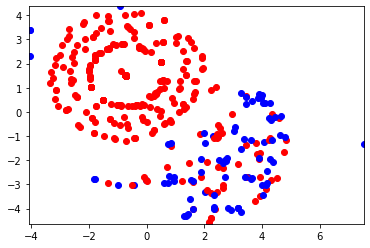

In [77]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot


for label, x, y in zip(category, x_coords, y_coords):
    if label == 0:
        plt.scatter(x, y, color='blue')
    else:
        plt.scatter(x, y, color='red')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()


In [78]:
# Calculate some additional "graph features"
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
    tx.run(
        """
        CALL gds.degree.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'degree'
        });
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
    tx.run(
        """  
        CALL gds.pageRank.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'pageRank'
        });  
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
    tx.run(
        """
        CALL gds.triangleCount.write('client_graph',{
            nodeLabels:['Client'],
            relationshipTypes:['TRANSACTED_WITH'],
            writeProperty:'triangles'
        });
        """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodePropertiesWritten,centralityDistribution,writeMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,2407,"{'p99': 44.00023651123047, 'min': 0.0, 'max': ...",5,219,0,0,"{'orientation': 'NATURAL', 'writeConcurrency':..."


,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,33,2407,20,False,"{'p99': 1.666365623474121, 'min': 0.1499996185...",123,0,28,"{'maxIterations': 20, 'writeConcurrency': 4, '..."


,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,createMillis,computeMillis,configuration
0,4,2407,550,2407,0,0,5,"{'writeConcurrency': 4, 'writeProperty': 'tria..."


In [79]:
# Calculate some additional "graph features" using cypher
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client)-[:PERFORMED]->(t:Transaction)
            WITH c, count(t) as num_transaction, sum(t.amount) as total_transaction_volume
            SET c.num_transactions=num_transaction, c.total_transaction_amnt=total_transaction_volume;
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (c:Client)-[:PERFORMED]->(t:Transaction{fraud:true})
            WITH c, count(t) as num_frauds
            SET c.num_frauds=num_frauds;
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

""


""


In [80]:
# Create projection with model data
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.create('fraud_graph',
            {
                Client:{
                    label:'model_data',
                    properties:{
                        embedding:{property:'embedding'},
                        pageRank:{property:'pageRank', defaultValue:0},
                        triangles:{property:'triangles', defaultValue:0},
                        degree:{property:'degree', defaultValue:0},
                        num_transactions:{property:'num_transactions',defaultValue:0},
                        total_transaction_amnt:{property:'total_transaction_amnt',defaultValue:0},
                        num_frauds:{property:'num_frauds',defaultValue:0},
                        is_fraudster:{property:'is_fraudster',defaultValue:0}
                    }
                }
            }, {
                TO: {type:'TO'} //I don't actually need this
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,"{'Client': {'label': 'model_data', 'properties...","{'TO': {'orientation': 'NATURAL', 'aggregation...",fraud_graph,460,0,30


In [81]:
# Train node classification & pick the best model
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.alpha.ml.nodeClassification.train('fraud_graph', {
            nodeLabels: ['Client'],
            modelName: 'fraud-model',
            featureProperties: ['embedding', 'triangles','num_frauds','num_transactions','pageRank'], 
            targetProperty: 'is_fraudster', 
            metrics: ['F1_WEIGHTED','ACCURACY'], 
            holdoutFraction: 0.2, 
            validationFolds: 5, 
            randomSeed: 2,
            params: [
                {penalty: 0, maxEpochs: 1000},
                {penalty: 0.5, maxEpochs: 1000},
                {penalty: 1.0, maxEpochs: 1000}
                ]
                }) YIELD modelInfo
            RETURN
            modelInfo.bestParameters AS winningModel,
            modelInfo.metrics.F1_WEIGHTED.outerTrain AS trainGraphScore,
            modelInfo.metrics.F1_WEIGHTED.test AS testGraphScore
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,winningModel,trainGraphScore,testGraphScore
0,"{'maxEpochs': 1000, 'minEpochs': 1, 'penalty':...",0.897122,0.842772


In [82]:
# Create projection with predict_data 
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.create('predict_graph',
            {
                Client:{
                    label:'predict_data',
                    properties:{
                        embedding:{property:'embedding'},
                        pageRank:{property:'pageRank', defaultValue:0},
                        triangles:{property:'triangles', defaultValue:0},
                        degree:{property:'degree', defaultValue:0},
                        num_transactions:{property:'num_transactions',defaultValue:0},
                        total_transaction_amnt:{property:'total_transaction_amnt',defaultValue:0},
                        num_frauds:{property:'num_frauds',defaultValue:0},
                        is_fraudster:{property:'is_fraudster',defaultValue:0}
                    }
                }
            }, {
                TO: {type:'TO'} //I don't actually need this
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,"{'Client': {'label': 'predict_data', 'properti...","{'TO': {'orientation': 'NATURAL', 'aggregation...",predict_graph,2407,0,36


In [83]:
# Make the predictions using node classification model
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.alpha.ml.nodeClassification.predict.mutate('predict_graph', {
                nodeLabels: ['Client'], //filter our the character nodes
                modelName: 'fraud-model',
                mutateProperty: 'predicted_fraudster',
                predictedProbabilityProperty: 'predicted_fraud_probability'
            })
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,nodePropertiesWritten,mutateMillis,postProcessingMillis,createMillis,computeMillis,configuration
0,4814,0,0,0,4,"{'modelName': 'fraud-model', 'predictedProbabi..."


In [84]:
# Write the predictions back to the database
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            CALL gds.graph.writeNodeProperties(
                'predict_graph',
                ['predicted_fraudster', 'predicted_fraud_probability'],
                ['Client']
            )
            """
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,writeMillis,graphName,nodeProperties,propertiesWritten
0,58,predict_graph,"[predicted_fraud_probability, predicted_frauds...",4814


In [85]:
# What have we predicted (suspect)
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            match (c:Client) where c.predicted_fraudster = $classLabel
            return c.name, c.predicted_fraudster, 
            apoc.coll.max(c.predicted_fraud_probability) as probability, c.predicted_fraud_probability
            order by probability desc limit 10
            """,
            classLabel=1
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,c.predicted_fraudster,probability,c.predicted_fraud_probability
0,Daniel Hendrix,1,0.624463,"[0.37553717645879675, 0.6244628235412026]"
1,Isabella Grant,1,0.597340,"[0.40265983062533245, 0.5973401693746672]"
2,Aubree David,1,0.595296,"[0.4047036632181505, 0.5952963367818489]"
3,Melanie Kent,1,0.566791,"[0.4332085199522581, 0.5667914800477415]"
4,Evelyn Craig,1,0.563061,"[0.4369388200572656, 0.5630611799427339]"
5,Andrea Sweet,1,0.561435,"[0.4385648917074156, 0.5614351082925839]"
6,Michael Cooper,1,0.560953,"[0.4390467775569373, 0.5609532224430623]"
7,Alyssa Garrett,1,0.556748,"[0.4432522374185583, 0.5567477625814412]"
8,Carlos Ward,1,0.555899,"[0.4441008524480418, 0.5558991475519578]"
9,Zoey Mendez,1,0.554998,"[0.4450020249535144, 0.5549979750464851]"


In [86]:
# What have we predicted (class 0)
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            match (c:Client) where c.predicted_fraudster = $classLabel
            return c.name, c.predicted_fraudster, 
            apoc.coll.max(c.predicted_fraud_probability) as probability, c.predicted_fraud_probability
            order by probability desc limit 10
            """,
            classLabel=0
        ).data()
    )
    df = pd.DataFrame(result)
    display(df)

,c.name,c.predicted_fraudster,probability,c.predicted_fraud_probability
0,Zoey Sexton,0,0.503621,"[0.5036210474877008, 0.49637895251229863]"
1,Annabelle Palmer,0,0.503443,"[0.503442930661117, 0.4965570693388824]"
2,Lily Saunders,0,0.503400,"[0.5033999002265033, 0.4966000997734962]"
3,Nolan Sanders,0,0.502991,"[0.5029913312790238, 0.49700866872097554]"
4,Eva Sullivan,0,0.502972,"[0.5029724321175865, 0.497027567882413]"
5,Kennedy Potts,0,0.502725,"[0.5027246770962374, 0.4972753229037621]"
6,Aubrey Cortez,0,0.502518,"[0.502518239277547, 0.49748176072245237]"
7,Gavin Solis,0,0.502511,"[0.5025113290287141, 0.4974886709712853]"
8,Riley Vincent,0,0.502304,"[0.5023041364419643, 0.49769586355803525]"
9,James Mason,0,0.502076,"[0.5020757100431338, 0.49792428995686583]"


In [87]:
# Clean up gds graph and model catalogue 
with driver.session(database = DB_NAME) as session:
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.beta.model.drop('fraud-model')").consume()
        )
    except:
        print()
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('client_graph')").consume()
        )
    except:
        print()
    try: 
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('fraud_graph')").consume()
        )
    except:
        print()
    try:
        session.read_transaction(lambda tx: 
            tx.run("CALL gds.graph.drop('predict_graph')").consume()  
        )
    except:
        print()

In [88]:
# Clean up temporary labels and properties
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction(lambda tx: 
        tx.run("MATCH (c:model_data) remove c:model_data").consume()
    )
    result = session.write_transaction(lambda tx: 
        tx.run("MATCH (c:predict_data) remove c:predict_data").consume()
    )
    result = session.write_transaction(lambda tx: 
        tx.run(
        """
        MATCH (c:Client) 
        remove  c.predicted_fraudster, 
                c.predicted_fraud_probability,
                c.embedding,
                //c.LouvainCommunity,
                c.is_fraudster,
                c:model_data,
                c:predict_data
        """).consume()
    )